# ocroseg

This is a deep learning model for page layout analysis / segmentation.

There are many different ways in which you can train and run it, but by default, it will simply return the text lines in a page image.

# Segmentation

Segmentation is carried out using the `ocroseg.Segmenter` class. This needs a model that you can download or train yourself.

In [4]:
%%bash
model=lowskew-000000259-011440.pt
test -f $model || wget --quiet -nd https://storage.googleapis.com/tmb-models/$model

In [19]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


The `Segmenter` object handles page segmentation using a DL model.

In [20]:
import ocroseg
seg = ocroseg.Segmenter("lowskew-000000259-011440.pt")
seg.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (10): ReLU()
  (11): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(64, 32, bidirectional=1)
    )
    (vlstm): RowwiseLSTM(
      (lstm): LSTM(64, 32, bidirectional=1)
    )
  )
  (12): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU()
  (15): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(32, 32

Let's segment a page with this.

(2000, 2592)


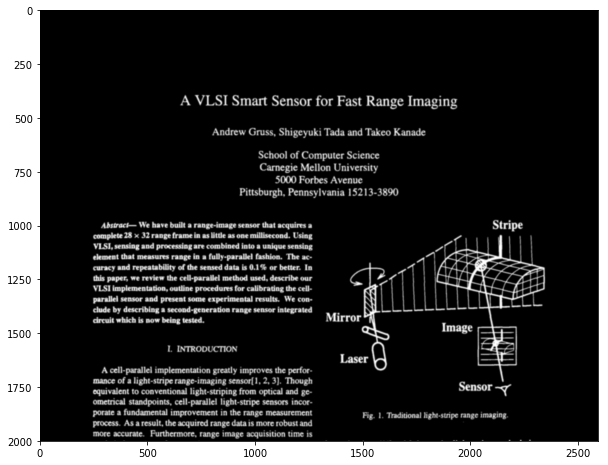

In [24]:
image = 1.0 - imread("testdata/W1P0.png")[:2000]
print image.shape
imshow(image)

The `extract_textlines` method returns a list of text line images, bounding boxes, etc.

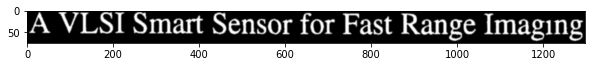

In [25]:
lines = seg.extract_textlines(image)
imshow(lines[0].line_image)

The segmenter accomplishes this by predicting seeds for each text line. With a bit of mathematical morphology, these seeds are then extended into a text line segmentation.

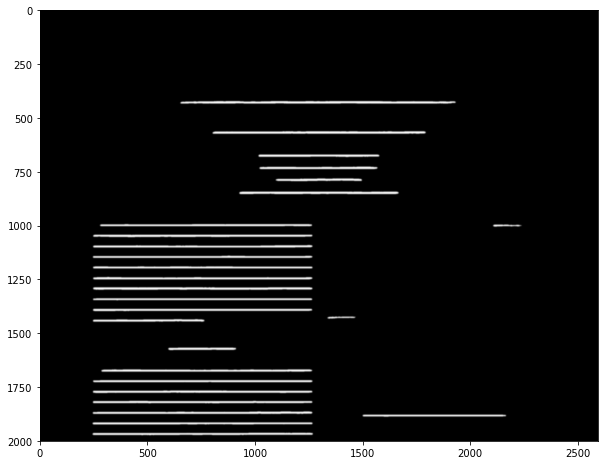

In [27]:
imshow(seg.lines)

# Training

The text line segmenter is trained using pairs of page images and line images stored in `tar` files.

In [28]:
%%bash
tar -ztvf testdata/framedlines.tgz | sed 6q

-rw-rw-r-- tmb/tmb      110404 2017-03-19 16:47 A001BIN.framed.png
-rw-rw-r-- tmb/tmb       10985 2017-03-16 16:15 A001BIN.lines.png
-rw-rw-r-- tmb/tmb       74671 2017-03-19 16:47 A002BIN.framed.png
-rw-rw-r-- tmb/tmb        8528 2017-03-16 16:15 A002BIN.lines.png
-rw-rw-r-- tmb/tmb      147716 2017-03-19 16:47 A003BIN.framed.png
-rw-rw-r-- tmb/tmb       12023 2017-03-16 16:15 A003BIN.lines.png


tar: write error


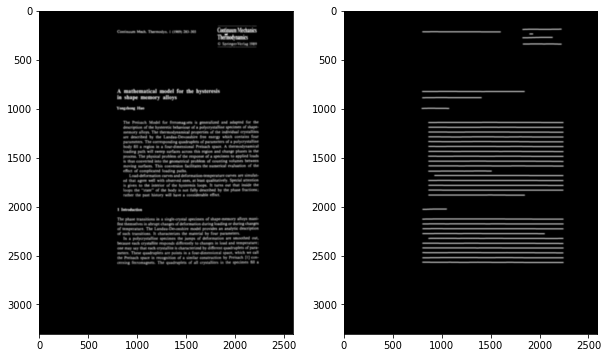

In [33]:
from dlinputs import tarrecords
sample = tarrecords.tariterator(open("testdata/framedlines.tgz")).next()
subplot(121); imshow(sample["framed.png"])
subplot(122); imshow(sample["lines.png"])

There are also some tools for data augmentation.

Generally, you can train these kinds of segmenters on any kind of image data, though they work best on properly binarized, rotation and skew-normalized page images. Note that by conventions, pages are white on black. You need to make sure that the model you load matches the kinds of pages you are trying to segment.


The actual models used are pretty complex and require LSTMs to function well, but for demonstration purposes, let's define and use a tiny layout analysis model. Look in `bigmodel.py` for a realistic model.

In [3]:
%%writefile tinymodel.py
def make_model():
    r = 3
    model = nn.Sequential(
        nn.Conv2d(1, 8, r, padding=r//2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(8, 1, r, padding=r//2),
        nn.Sigmoid()
    )
    return model

Overwriting tinymodel.py


In [11]:
%%bash
./ocroseg-train -d testdata/framedlines.tgz --maxtrain 10 -M tinymodel.py --display 0

raw sample:
__key__ 'A001BIN'
__source__ 'testdata/framedlines.tgz'
lines.png float32 (3300, 2592)
png float32 (3300, 2592)

preprocessed sample:
__key__ <type 'list'> ['A005BIN']
__source__ <type 'list'> ['testdata/framedlines.tgz']
input float32 (1, 3300, 2592, 1)
mask float32 (1, 3300, 2592, 1)
output float32 (1, 3300, 2592, 1)

ntrain 0
model:
Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Sigmoid()
)

0 0 ['A00BBIN'] 0.26948798 ['A00BBIN'] 0.41169813 0.57671887 lr 0.03
1 1 ['A00CBIN'] 0.2700115 ['A00CBIN'] 0.41164824 0.5702204 lr 0.03
2 2 ['A002BIN'] 0.2738667 ['A002BIN'] 0.41362688 0.5677617 lr 0.03
3 3 ['A00JBIN'] 0.26942334 ['A00JBIN'] 0.407331 0.55966264 lr 0.03
4 4 ['A008BIN'] 0.2651262 ['A008BIN'] 0.40311012 0.5607917 lr 0.03
5 5 ['A004BIN'] 0.26518792 ['A004BIN'] 